# Plot Individual ROH
Make nice plots of whole genome, in Karyotype style.

Plot every chromosome: Centromer, and then list of ROH Blocks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as pe
import h5py   # For Processing HDF5s
from scipy.stats import gaussian_kde

import socket
import os as os
import sys as sys
import multiprocessing as mp


socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
    print("Harald's Machine Detected")
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
Harald's Machine Detected
/home/harald/git/HAPSBURG
CPU Count: 4


In [2]:
def load_roh(iid, ch, path_folder = "./Empirical/1240k/", prefix_out = "e01/"):
    """Load the ROH Dataframe for Individual iid and 
    Chromosome ch"""
    path = path_folder +  iid + "/chr" + str(ch) + "/" + prefix_out+ "/roh.csv"
    roh_df = pd.read_csv(path)    
    return roh_df

def post_process_roh_df(df, min_cm=4, snp_cm=100, output=False):
    """Post Process ROH Dataframe.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df

def load_h5(path, output=True):
        """Load and return the HDF5 File from Path"""
        f = h5py.File(path, "r")  # Load for Sanity Check. See below!
        if output == True:
            print("\nLoaded %i variants" % np.shape(f["calldata/GT"])[0])
            print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
            # print(list(f["calldata"].keys()))
            # print(list(f["variants"].keys()))
            print(f"HDF5 loaded from {path}")
        return f
    
def chrom_length(ch, output=False):
    """Get and retrun length of Chromosome"""
    
    path1000G = "./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr" + str(ch) + ".hdf5"  # Path of 1000G (without chromosome part)
    f = load_h5(path1000G, output=output)
    rec = np.array(f["variants/MAP"])
    l = np.max(rec)
    return rec, l

def load_individual_roh(iid, min_cm=4, snp_cm=50, path_folder = "./Empirical/1240k/", 
                        prefix_out = "e01/", folder="./Empirical/1240k/"):
    """Load ROH of one Individual"""
    df_rohs = []
    for i in range(1,23):
        df_roh = load_roh(iid=iid, ch=i, path_folder = folder, prefix_out = prefix_out)
        df_roh = post_process_roh_df(df_roh, min_cm=min_cm, snp_cm=snp_cm) # Standad PP
        df_rohs.append(df_roh)
    return df_rohs

def load_bad_areas(path="./Data/1000Genomes/Markers/1240k/snp_density.csv", min_snps=50):
    """Load areas of low SNP density, and return list of Dataframes 
    (one for each chromosome)"""
    df_lows = []
    
    for i in range(1,23):
        df_t = pd.read_csv(path, sep="\t")
        df_t = df_t[df_t["chr"]==i]
        df_t = df_t[df_t["counts"]<min_snps]
        df_lows.append(df_t)
    return df_lows

In [5]:
def plot_chromosome(ax, l, x_pos, lw=24, df_roh = [], df_low = []):
    """Plot a Chromosome of length l with centromer ctr on ax 
    at x_pos"""
    ln, = ax.plot([x_pos, x_pos], [-0.05,l+0.05], lw = lw, color="lightgray",
                      solid_capstyle = 'round', zorder=0,
                  path_effects=[pe.Stroke(linewidth=lw+3, foreground='k'), pe.Normal()])
    
    ### Plot the ROH List if given
    if len(df_roh) > 0:
        starts, ends = df_roh["StartM"].values, df_roh["EndM"].values
        
        for i in range(len(df_roh)):
            ax.plot([x_pos, x_pos], [starts[i], ends[i]], lw=lw, color="maroon", 
                    zorder=1, alpha=1.0, solid_capstyle="butt")
    
    ### Plot shadows of bad areas
    if len(df_low)>0:
        starts, ends = df_low["StartM"].values, df_low["EndM"].values
        
        for i in range(len(df_low)):
            ax.plot([x_pos, x_pos], [starts[i], ends[i]], lw=lw, color="k", 
                    zorder=2, alpha=0.8, solid_capstyle="butt")
        
            
def plot_roh_individual(iid="MA89", fs=12, figsize=(8,8), save=False, min_cm=4, snp_cm=50, 
                        folder="./Empirical/1240k/MarcusAncs/", prefix_out="e01/", plot_bad=True,
                       title=True):
    """Plot ROH in one ancient Individual"""
    
    ### Load the Data (could be done seperately)
    df_rohs = load_individual_roh(iid, min_cm=min_cm, snp_cm=snp_cm, folder=folder, prefix_out=prefix_out)
    if plot_bad:
        df_lows = load_bad_areas(min_snps=snp_cm)  # Load low density areas of the genome
    else:
        df_lows=[[] for _ in range(23)]
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
    gs.update(hspace=0.1) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
        
    ### Plot the First 11 Chromosomes
    for i in range(1,12):
        rec, l = chrom_length(i)
        plot_chromosome(ax, l, x_pos=(i), df_roh=df_rohs[i-1], df_low=df_lows[i-1])  
    
    ### Plot the Second 11 Chromosomes
    for i in range(12,23):
        rec, l = chrom_length(i)
        plot_chromosome(ax1, l, x_pos=(i - 11), df_roh=df_rohs[i-1], df_low=df_lows[i-1])

    ### Set the Plot Limits
    ax.set_xlim([0.3, 11.5])
    ax1.set_xlim([0.3, 11.5])

    ax.set_ylim([-0.3,3.3])
    ax1.set_ylim([-0.3, 2.05])

    ### Turn off the Y Axis
    for ax0 in [ax, ax1]:
        ax0.spines['right'].set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['bottom'].set_visible(False)
        ax0.yaxis.set_tick_params(labelsize=fs)

    rang = np.arange(1,12)
    ax.set_xticks(rang)
    ax.set_xticklabels(rang, fontsize=fs)

    ax1.set_xticks(rang)
    ax1.set_xticklabels(rang+11, fontsize=fs)
    ax1.set_xticklabels(rang+11, fontsize=fs)

    if save==True:
        savepath="./figures_test/" + iid + "_allchrroh.pdf"
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)

        savepath="./figures_test/" + iid + "_allchrroh.png"
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    
    if title:
        ax.set_title(iid, fontsize=fs*2)
    plt.show()

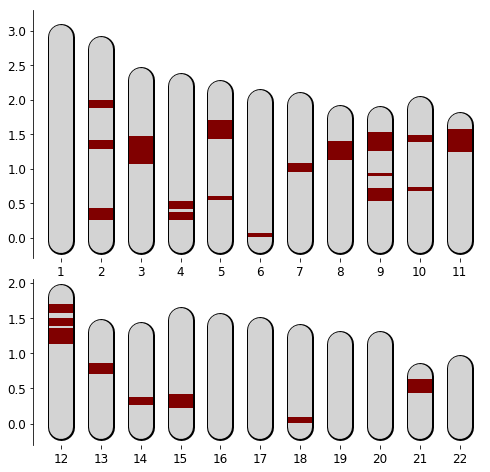

CPU times: user 615 ms, sys: 194 ms, total: 809 ms
Wall time: 431 ms


In [10]:
%%time
plot_roh_individual(iid="MA89", save=False, folder="./Empirical/1240k/MarcusAncs/", title=False,
                   plot_bad=False)  # MA89 #Ogl_5
#plot_roh_individual(iid="IPK12", save=False, folder="./Empirical/1240k/SA_Readcounts/", 
 #                   prefix_out="", min_cm=4, plot_bad=False)  # MA89 #Ogl_5

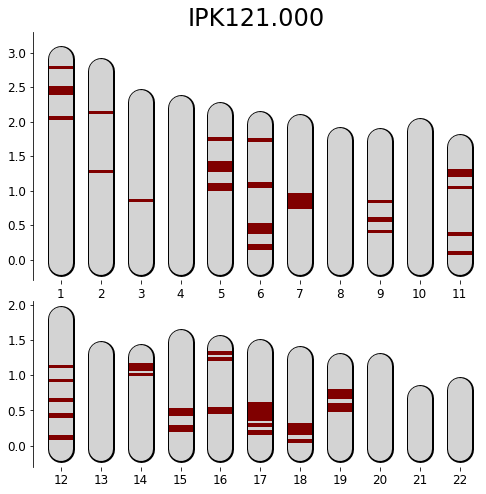

In [13]:
plot_roh_individual(iid="IPK121.000", save=False, folder="./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", 
                    prefix_out="", min_cm=4, plot_bad=False)  # MA89 #Ogl_5

# Plot Distribution of different Relatedness Classes

In [11]:
def expected_block_pdf(x, chr_l, m):
    """Gives back the pdfs for Blocks of Length l [Morgan]
    on a Chromosome of Length [Morgan].
    m: Nr of Meiosis.
    Return PDF (per Morgan)"""
    pdf0 = (chr_l - x) * m**2 * np.exp(-x * m)
    pdf1 = 2 * np.exp(- x * m) * m 
    return (pdf0 + pdf1) * (x < chr_l)  # If x < chr_l return 0

def expected_block_pdf_chromosomes(x, chr_lgts, m):
    """Calculate the PDF of ROH blocks of length x [Morgan]
    for m Recombination events
    x: Can be Array
    chr_lgts: Array of all chromosome lengths [in Morgan]
    Return PDF (per Morgan)"""
    pdfs = [expected_block_pdf(x, chr_l, m) for chr_l in chr_lgts]
    pdf_full = np.sum(pdfs, axis=0)
    return pdf_full

def coal_prob(m, comm_anc=1):
    """Calculate Coalescence Probability.
    m: Nr of Meiosis
    comm_anc: How many common ancestors"""
    c_prob = comm_anc * (1 / 2) ** m
    return c_prob

def exp_blocks_full_individual(x, m, comm_anc=1):
    """Calculates the Expected Nr of ROH Blocks per Morgan for full Individual
    x: Array of Block Lenths
    m: Nr of Meisois
    comm_anc: Nr of Ancestry Loops"""
    
    chr_lgts = [chrom_length(ch)[1] for ch in range(1,23)]
    
    pdf_full = expected_block_pdf_chromosomes(x, chr_lgts, m)
    c_prob = coal_prob(m, comm_anc)
    exp_blocks = pdf_full * c_prob
    return exp_blocks

In [12]:
### Create Some Test Case
ch_lgts = [chrom_length(ch)[1] for ch in range(1,23)]
print(np.sum(ch_lgts)) ## Total Length of Human Genome (in Morgan)

35.44562


In [13]:
def plot_pde_indivdiual(iid="MA89", min_cm=4, snp_cm=50, bw_cm=4, kde_plot=False, plotlim=[4,100], savepath="", 
                        folder="./Empirical/1240k/", prefix_out="e01/"):
    """Plot Histograms/PDEs of ROH Distribution for one Individual
    bw_cm: Length of one Bin (in cM)"""
    #######################
    ### Load And Prepare Data
    df_rohs = load_individual_roh(iid=iid, min_cm=min_cm, snp_cm=snp_cm, 
                                  folder=folder, prefix_out=prefix_out)
    df_roh = pd.concat(df_rohs)

    bins = np.arange(plotlim[0], plotlim[1], bw_cm)
    bin_mean = (bins[1:] + bins[:-1]) / 2.0  # Mean of each bin

    block_pdf1 = exp_blocks_full_individual(bin_mean/100, m=6, comm_anc=4)
    block_pdf2 = exp_blocks_full_individual(bin_mean/100, m=6, comm_anc=8)
    block_pdf3 = exp_blocks_full_individual(bin_mean/100, m=5, comm_anc=4)

    ### Do the Gaussian KDE:
    kde = gaussian_kde(df_roh["lengthM"]*100) # KDE per cM
    #kde = gaussian_kde()
    #######################
    ### Do the Actual Plot
    fs = 16

    plt.figure(figsize=(8,6))
    plt.hist(df_roh["lengthM"]*100, bins=bins, ec="k", fc="dodgerblue", label="Observed ROH")

    plt.plot(bin_mean, bw_cm * block_pdf2/100, c="red", label="Double First Cousin", lw=3) # Plot Density Per cM (adjusted for bin width)
    plt.plot(bin_mean, bw_cm * block_pdf3/100, c="green", label="Nephew / Full Aunt", lw=3) # Plot Density Per cM (adjusted for bin width)
    plt.plot(bin_mean, bw_cm * block_pdf1/100, c="orange", label="First Cousins", lw=3) # Plot Density Per cM (adjusted for bin width)
    
    if kde_plot==True:
        plt.plot(bin_mean, bw_cm * kde(bin_mean) * len(df_roh), "k--", label="KDE of observed ROH", lw=2)

    plt.xlabel("ROH Length [cm]", fontsize=fs)
    plt.ylabel(f"Number per {bw_cm} cM Bin", fontsize=fs)
    plt.title(f"Individual: {iid}", fontsize=fs)
    leg = plt.legend(loc = "upper right", fontsize=fs)
    leg.set_title("Parents being...", prop = {'size':fs})
    
    plt.tick_params(axis='both', which='major', labelsize=fs)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

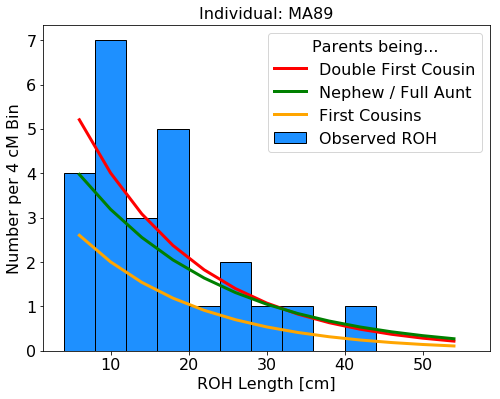

In [14]:
plot_pde_indivdiual(iid="MA89", min_cm=3, bw_cm=4, kde_plot=False, plotlim=[4, 60], 
                    savepath="./figures/talk_harvard/MA89_density.png", folder="./Empirical/1240k/MarcusAncs/") # Ogl_5

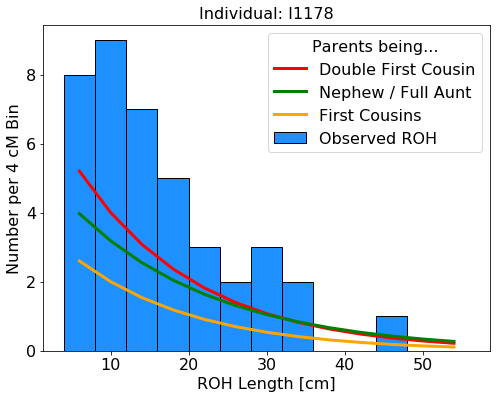

In [42]:
plot_pde_indivdiual(iid="I1178", min_cm=3, bw_cm=4, kde_plot=False, plotlim=[4, 60], 
                    savepath="", folder="./Empirical/Eigenstrat/Reichall/", prefix_out="") # Ogl_5

### Calcualte Numerical Expecations for NR and Sum of ROH

In [84]:
### Sanity Check: Calculate total expected Block Sharing Lengths:
x_arr = np.linspace(0.04, 2.0, 1000)
bin_width=x_arr[1] - x_arr[0]

block_pdf = exp_blocks_full_individual(x_arr+bin_width/2, m=3, comm_anc=2)  # That should be full first Cousin m=6/comm_ancs=4
e_blocks = block_pdf * bin_width

e_lengths = e_blocks * x_arr

print(f"Total Expected Nr of Blocks: {np.sum(e_blocks):.4f}")
print(f"Expected Sum of Block Sharing: {np.sum(e_lengths)*100:.4f} cM")

Total Expected Nr of Blocks: 27.7366
Expected Sum of Block Sharing: 861.3788 cM


# Area 51

##Try Plotting various relationships in one plot

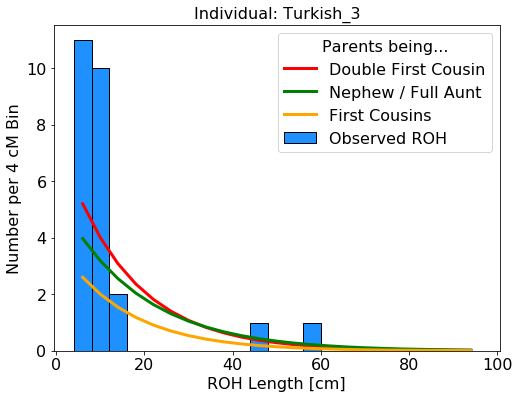

In [23]:
plot_pde_indivdiual(iid="Turkish_3", min_cm=3, bw_cm=4, kde_plot=False, plotlim=[4, 100], savepath="", folder="./Empirical/1240k/HO/") # Ogl_5